## Paper Machine Sheet Break Prediction with CNN model.  Subset where x28 feature is 96.

## This notebook runs the same data cleaning steps, and prepares the data to fit a Random Forest to select best features using  Feature Importance and Permutation Importance from the sensor features as awell as the two derivatives of these feature values. 

### Reference and Licence

### Dataset: Rare Event Classification in Multivariate Time Series
 ### 2018-10-01  Chitta Ranjan, Markku Mustonen, Kamran Paynabar, Karim Pourak
### https://deeplearn.org/arxiv/48599/dataset:-rare-event-classification-in-multivariate-time-series

#### Summary
#### This finds best feature sets using the X28 = 96 Categorical subset.

## Workflow
#### Clean data as in other models prior to feature reduction.
 
- Segregate data on the most frequent categorical-like feature in: x28 == 96
- drop short periods between faults - see below.
- drop fault conditions that are separted from the running condition by missing data.
- Create two derivative sets with time relative to the sensor position features, dF/dt & dF/dt^2
- Scale the data

- join the position, velocity, and acceleration sets 
- Relabel the fault label to 2, and the preceding 5 time slices to 1. Other normals stay as 0.

- Split the data into train & test sets stratify on the 0, 1, & 2 labels.  The split will be random rather than front end, back end.
- Run a Random Forest Classifier to classify each sample in time (the time slices are not stacked into an image)

 - Use Feature Importance and Permutation Importance to find different sets of features to retain and complete the image classification modelling.
 


In [1]:
#Import General Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

#import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,  classification_report

#from random import random

import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('processminer-rare-event-mts - data.csv')

In [3]:
df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [4]:
df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)

In [5]:
df['x28'].nunique()

8

In [6]:
df['x28'].value_counts()

96     6574
82     4378
118    2646
139    1807
84     1313
112    1235
93      419
51       26
Name: x28, dtype: int64

### The features behavior varies based on the x28 value, as seen in the EDA notebook.   So as in the first model, this feature / permutation importance will focus on samples where feature x28 is equal to 96.


In [7]:
df = df[df['x28']==96]


In [8]:
df.shape

(6574, 63)

In [9]:
df = df.drop(df[['x28']], axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6574 entries, 0 to 18397
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    6574 non-null   datetime64[ns]
 1   y       6574 non-null   int64         
 2   x1      6574 non-null   float64       
 3   x2      6574 non-null   float64       
 4   x3      6574 non-null   float64       
 5   x4      6574 non-null   float64       
 6   x5      6574 non-null   float64       
 7   x6      6574 non-null   float64       
 8   x7      6574 non-null   float64       
 9   x8      6574 non-null   float64       
 10  x9      6574 non-null   float64       
 11  x10     6574 non-null   float64       
 12  x11     6574 non-null   float64       
 13  x12     6574 non-null   float64       
 14  x13     6574 non-null   float64       
 15  x14     6574 non-null   float64       
 16  x15     6574 non-null   float64       
 17  x16     6574 non-null   float64       
 18  x17    

#### There are 2 occasions of mislableled faults in the X28 = 96 subset. The break is labelled but there isn't a distruption in run time. These are at May 13 18:14 hours and May 14 09:30 hours. Reset the fault label to 0 for these.

In [11]:
print(df['y'][df['time']==pd.to_datetime('1999-05-13 18:14:00')], '\n', df['y'][df['time']==pd.to_datetime('1999-05-14 09:30:00')])

8475    1
Name: y, dtype: int64 
 8933    1
Name: y, dtype: int64


In [12]:
df['y'][df['time']==pd.to_datetime('1999-05-13 18:14:00')]=0
df['y'][df['time']==pd.to_datetime('1999-05-14 09:30:00')]=0

In [13]:
print(df['y'][df['time']==pd.to_datetime('1999-05-13 18:14:00')], '\n', df['y'][df['time']==pd.to_datetime('1999-05-14 09:30:00')])

8475    0
Name: y, dtype: int64 
 8933    0
Name: y, dtype: int64


#### There is a 68 minute gap from May 12 21:40 hours to a fault condition at 22:48 hours.  This fault will be removed since there are missing time slices corresponding with a warning state.

In [14]:
df = df[df['time'] != pd.to_datetime('1999-05-12 22:48:00')]
len(df)

6573

### Check the minimum number of samples between tear conditions

In [15]:
dfy = pd.DataFrame(columns = ['y', 'gaps'])
dfy['y'] = df['y'][df['y']==1]

Inds = dfy.index
gaps=[]
for i in range(len(Inds)):
    if i != 0:
        gaps.append(Inds[i] - Inds[i-1])
    else:
        gaps.append(Inds[i])
dfy['gaps'] = gaps
print('Mininmum samples between faults: ', min(dfy['gaps']))

dfy.head()

Mininmum samples between faults:  3


,y,gaps
259,1,259
2298,1,2039
2303,1,5
2308,1,5
2312,1,4


Number of occurances of less than 6 time samples between faults: 11


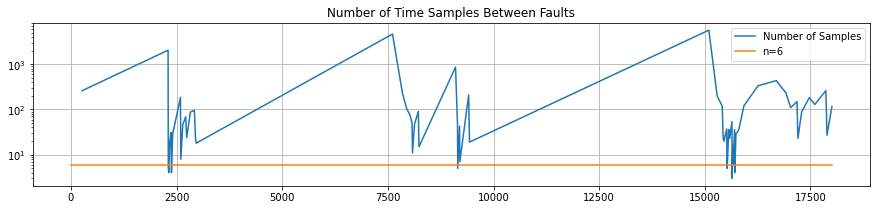

In [16]:
plt.figure(figsize=(15,3))
dfy['gaps'].plot(label='Number of Samples')
plt.plot([0, 18000], [6,6], label= 'n=6')
plt.title('Number of Time Samples Between Faults')
plt.yscale('log')
plt.grid()
plt.legend()
print(('Number of occurances of less than 6 time samples between faults: {}').format(sum(dfy['gaps']<=6)) )
plt.show()

The ramps in the above chart correspond to dropped data for x28 values not equal to 96.  The chart plot the original index on the x axis.

These 11 faults will be dropped form this iteration.  Future attempts could include the 5 sample cases, but the missing sample will need to be replaced with zeros or an avergae of normal samples.

In [17]:
# Drop the faults and related samples where there are fewer than 6 samples between faults
Ind_6 = dfy[dfy['gaps']<7].index
for i in Ind_6:
    for j in range( dfy.loc[i][1] ):
        df['y'].loc[i-j] = 10

df = df[df['y']!=10]

print('Number of remaining faults is: ', df['y'].sum())
print('remaing shape of df is: ', df.shape)       

Number of remaining faults is:  58
remaing shape of df is:  (6521, 62)


In [18]:
# Reset the index
df=df.reset_index()

In [19]:
master_index = df['time']

In [20]:
# Repeat to get a new dfy with remaining faults and gaps
dfy2 = pd.DataFrame(columns = ['y', 'gaps'])
dfy2['y'] = df['y'][df['y']==1]

Inds2 = dfy2.index
gaps=[]
for i in range(len(Inds2)):
    if i != 0:
        gaps.append(Inds2[i] - Inds2[i-1])
    else:
        gaps.append(Inds2[i])
dfy2['gaps'] = gaps
print('Mininmum samples between faults: ', min(dfy2['gaps']), 'Maximum samples between faults is: ', max(dfy2['gaps']) )

dfy2.head()

Mininmum samples between faults:  7 Maximum samples between faults is:  865


,y,gaps
259,1,259
536,1,277
554,1,18
585,1,31
593,1,8


Number of occurances of less than 6 time samples between faults: 0


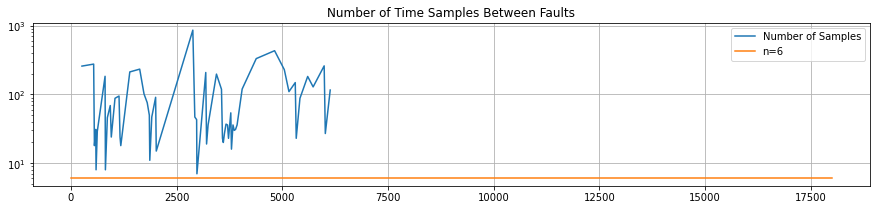

In [21]:
plt.figure(figsize=(15,3))
dfy2['gaps'].plot(label='Number of Samples')
plt.plot([0, 18000], [6,6], label= 'n=6')
plt.title('Number of Time Samples Between Faults')
plt.yscale('log')
plt.grid()
plt.legend()
print(('Number of occurances of less than 6 time samples between faults: {}').format( sum(dfy2['gaps']<=6)) )
plt.show()

### Now build a single and double derivative ('velocity' & 'acceleration') datasets, fixing the time delta at 2 (minutes) and ignore the time skipped after a sheet break.  These values at restart will be set to zero.

In [22]:
df.columns

Index(['index', 'time', 'y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8',
       'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18',
       'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49',
       'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59',
       'x60', 'x61'],
      dtype='object')

In [23]:
vel_cols = ['time', 'y']
acc_cols = ['time', 'y']
for item in df.columns[3:]:
    vel_cols.append(item + '_vel')
    acc_cols.append(item + '_acc')

In [24]:
df_vel = pd.DataFrame(columns = vel_cols)
df_vel['time'] = df['time']
df_vel['y'] = df['y']

df_vel.iloc[0,2:] = 0
df_vel.iloc[1:,2:] = (np.array( df.iloc[1:,3:]) - np.array( df.iloc[0:-1,3:]) )/2
# Show df_vel at the first fault, index 259
df_vel[257:262]

,time,y,x1_vel,x2_vel,x3_vel,x4_vel,x5_vel,x6_vel,x7_vel,x8_vel,...,x52_vel,x53_vel,x54_vel,x55_vel,x56_vel,x57_vel,x58_vel,x59_vel,x60_vel,x61_vel
257,1999-05-01 08:34:00,0,-0.005316,0.091098,0.011393,-0.741455,-0.055382,0.017959,0.0,0.0,...,0.00232,0.0,-0.000047,-4.334595,-0.844025,-0.032043,0.000205,0.38213,-0.000008,0.0
258,1999-05-01 08:36:00,0,-0.035834,0.003866,-0.08779,1.015457,0.026054,0.452881,0.0,0.0,...,0.002319,0.0,-0.000047,-2.872131,-0.844025,-0.288391,0.000206,0.482708,-0.000008,0.0
259,1999-05-01 08:38:00,1,-0.020811,-4.732099,-4.378312,-0.009689,0.026055,0.171173,0.0,0.0,...,0.002319,0.0,-0.000047,-0.299256,0.386094,-0.180054,0.000108,0.486832,-0.000008,0.5
260,1999-05-01 10:50:00,0,-0.436124,4.672384,4.379025,-37.891762,0.702729,-34.105827,0.0,0.0,...,-2.475219,-6.729492,-0.072169,-10.172424,-39.966156,1.37027,-0.004175,-0.025391,-0.00053,-0.5
261,1999-05-01 10:52:00,0,-0.064704,-0.541601,-0.580691,2.213219,-0.47393,1.29126,0.0,0.0,...,0.007324,0.028687,0.000415,14.164307,2.822342,0.061035,-0.00095,-0.194592,-0.000008,0.0


In [25]:
df_vel[257:262]

,time,y,x1_vel,x2_vel,x3_vel,x4_vel,x5_vel,x6_vel,x7_vel,x8_vel,...,x52_vel,x53_vel,x54_vel,x55_vel,x56_vel,x57_vel,x58_vel,x59_vel,x60_vel,x61_vel
257,1999-05-01 08:34:00,0,-0.005316,0.091098,0.011393,-0.741455,-0.055382,0.017959,0.0,0.0,...,0.00232,0.0,-0.000047,-4.334595,-0.844025,-0.032043,0.000205,0.38213,-0.000008,0.0
258,1999-05-01 08:36:00,0,-0.035834,0.003866,-0.08779,1.015457,0.026054,0.452881,0.0,0.0,...,0.002319,0.0,-0.000047,-2.872131,-0.844025,-0.288391,0.000206,0.482708,-0.000008,0.0
259,1999-05-01 08:38:00,1,-0.020811,-4.732099,-4.378312,-0.009689,0.026055,0.171173,0.0,0.0,...,0.002319,0.0,-0.000047,-0.299256,0.386094,-0.180054,0.000108,0.486832,-0.000008,0.5
260,1999-05-01 10:50:00,0,-0.436124,4.672384,4.379025,-37.891762,0.702729,-34.105827,0.0,0.0,...,-2.475219,-6.729492,-0.072169,-10.172424,-39.966156,1.37027,-0.004175,-0.025391,-0.00053,-0.5
261,1999-05-01 10:52:00,0,-0.064704,-0.541601,-0.580691,2.213219,-0.47393,1.29126,0.0,0.0,...,0.007324,0.028687,0.000415,14.164307,2.822342,0.061035,-0.00095,-0.194592,-0.000008,0.0


#### As shown above in time steps 259 to 260, there is a re-start of the process and the derivative ('velocity') is not representative.
#### Therefore, reset values after each sheet break on df_vel to zero.   This will also eliminate large swings in the double derivative.  
#### Then repeat with the 'acceleration' data.

In [26]:
Indx = 0

for row in range(len(dfy2)):
    gap = dfy2.iloc[row,1]
    Indx = Indx + gap 
    df_vel.iloc[Indx+1, 2:] = 0

df_vel[257:262]

,time,y,x1_vel,x2_vel,x3_vel,x4_vel,x5_vel,x6_vel,x7_vel,x8_vel,...,x52_vel,x53_vel,x54_vel,x55_vel,x56_vel,x57_vel,x58_vel,x59_vel,x60_vel,x61_vel
257,1999-05-01 08:34:00,0,-0.005316,0.091098,0.011393,-0.741455,-0.055382,0.017959,0.0,0.0,...,0.00232,0.0,-0.000047,-4.334595,-0.844025,-0.032043,0.000205,0.38213,-0.000008,0.0
258,1999-05-01 08:36:00,0,-0.035834,0.003866,-0.08779,1.015457,0.026054,0.452881,0.0,0.0,...,0.002319,0.0,-0.000047,-2.872131,-0.844025,-0.288391,0.000206,0.482708,-0.000008,0.0
259,1999-05-01 08:38:00,1,-0.020811,-4.732099,-4.378312,-0.009689,0.026055,0.171173,0.0,0.0,...,0.002319,0.0,-0.000047,-0.299256,0.386094,-0.180054,0.000108,0.486832,-0.000008,0.5
260,1999-05-01 10:50:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,1999-05-01 10:52:00,0,-0.064704,-0.541601,-0.580691,2.213219,-0.47393,1.29126,0.0,0.0,...,0.007324,0.028687,0.000415,14.164307,2.822342,0.061035,-0.00095,-0.194592,-0.000008,0.0


In [27]:
df_vel.tail()

,time,y,x1_vel,x2_vel,x3_vel,x4_vel,x5_vel,x6_vel,x7_vel,x8_vel,...,x52_vel,x53_vel,x54_vel,x55_vel,x56_vel,x57_vel,x58_vel,x59_vel,x60_vel,x61_vel
6516,1999-05-28 23:58:00,0,-0.006917,0.025591,0.070167,0.872742,0.014526,-0.310898,-0.009918,0.0,...,0.0,0.0,0.000463,-3.902955,-1.193726,0.305206,0.0002,-0.087388,0.000004,0.0
6517,1999-05-29 00:00:00,0,0.016727,-0.076672,0.077746,-1.036133,0.014518,-0.310898,0.0,0.0,...,0.0,0.0,0.000463,-3.218444,-0.780769,-0.02774,0.0002,-0.360169,0.000004,0.0
6518,1999-05-29 00:02:00,0,0.00872,-0.09148,-0.113668,0.874512,0.014519,-0.310898,0.0,-0.005035,...,0.0,0.0,0.000463,1.150695,0.0,-0.246949,0.001352,0.222836,0.000004,0.0
6519,1999-05-29 00:04:00,0,0.001852,-0.015371,0.02634,0.340485,0.014526,-0.310898,0.0,0.0,...,0.0,0.0,0.000463,-0.322143,0.0,0.274689,-0.000217,0.384941,0.000004,0.0
6520,1999-05-29 00:06:00,0,-0.009069,0.081663,0.103076,0.340469,0.014519,0.138978,0.0,0.0,...,0.0,0.0,0.000462,-0.374085,0.0,0.064087,-0.000217,-0.485954,0.000004,0.0


In [28]:
df_acc = pd.DataFrame(columns = acc_cols)
df_acc['time'] = df['time']
df_acc['y'] = df['y']

df_acc.iloc[0,2:] = 0
df_acc.iloc[1:,2:] = (np.array( df_vel.iloc[1:,2:]) - np.array( df_vel.iloc[0:-1,2:]) )/2

df_acc[257:262]

,time,y,x1_acc,x2_acc,x3_acc,x4_acc,x5_acc,x6_acc,x7_acc,x8_acc,...,x52_acc,x53_acc,x54_acc,x55_acc,x56_acc,x57_acc,x58_acc,x59_acc,x60_acc,x61_acc
257,1999-05-01 08:34:00,0,-0.00744,0.093717,-0.003459,-0.858231,0.028099,0.000007,0.0,0.0,...,0.0,0.0,0.0,-4.48407,-0.0,-0.176239,0.0,0.08635,-0.0,0.0
258,1999-05-01 08:36:00,0,-0.015259,-0.043616,-0.049592,0.878456,0.040718,0.217461,0.0,0.0,...,-0.0,0.0,0.0,0.731232,-0.0,-0.128174,0.0,0.050289,0.0,0.0
259,1999-05-01 08:38:00,1,0.007512,-2.367982,-2.145261,-0.512573,0.0,-0.140854,0.0,0.0,...,-0.0,0.0,-0.0,1.286438,0.615059,0.054169,-0.000049,0.002062,0.0,0.25
260,1999-05-01 10:50:00,0,0.010406,2.366049,2.189156,0.004845,-0.013027,-0.085587,0.0,0.0,...,-0.001159,0.0,0.000024,0.149628,-0.193047,0.090027,-0.000054,-0.243416,0.000004,-0.25
261,1999-05-01 10:52:00,0,-0.032352,-0.270801,-0.290345,1.10661,-0.236965,0.64563,0.0,0.0,...,0.003662,0.014343,0.000208,7.082153,1.411171,0.030517,-0.000475,-0.097296,-0.000004,0.0


In [29]:
Indx = 0

for row in range(len(dfy2)):
    gap = dfy2.iloc[row,1]
    Indx = Indx + gap 
    df_acc.iloc[Indx+1, 2:] = 0

df_acc[257:262]

,time,y,x1_acc,x2_acc,x3_acc,x4_acc,x5_acc,x6_acc,x7_acc,x8_acc,...,x52_acc,x53_acc,x54_acc,x55_acc,x56_acc,x57_acc,x58_acc,x59_acc,x60_acc,x61_acc
257,1999-05-01 08:34:00,0,-0.00744,0.093717,-0.003459,-0.858231,0.028099,0.000007,0.0,0.0,...,0.0,0.0,0.0,-4.48407,-0.0,-0.176239,0.0,0.08635,-0.0,0.0
258,1999-05-01 08:36:00,0,-0.015259,-0.043616,-0.049592,0.878456,0.040718,0.217461,0.0,0.0,...,-0.0,0.0,0.0,0.731232,-0.0,-0.128174,0.0,0.050289,0.0,0.0
259,1999-05-01 08:38:00,1,0.007512,-2.367982,-2.145261,-0.512573,0.0,-0.140854,0.0,0.0,...,-0.0,0.0,-0.0,1.286438,0.615059,0.054169,-0.000049,0.002062,0.0,0.25
260,1999-05-01 10:50:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,1999-05-01 10:52:00,0,-0.032352,-0.270801,-0.290345,1.10661,-0.236965,0.64563,0.0,0.0,...,0.003662,0.014343,0.000208,7.082153,1.411171,0.030517,-0.000475,-0.097296,-0.000004,0.0


In [30]:
df_acc.tail()

,time,y,x1_acc,x2_acc,x3_acc,x4_acc,x5_acc,x6_acc,x7_acc,x8_acc,...,x52_acc,x53_acc,x54_acc,x55_acc,x56_acc,x57_acc,x58_acc,x59_acc,x60_acc,x61_acc
6516,1999-05-28 23:58:00,0,-0.004143,-0.007702,0.019599,0.564797,0.000004,-0.328171,-0.004959,0.0,...,0.0,0.0,0.0,-4.234711,-1.601315,0.465423,0.000583,-0.22411,-0.0,0.0
6517,1999-05-29 00:00:00,0,0.011822,-0.051131,0.003789,-0.954438,-0.000004,0.0,0.004959,0.0,...,0.0,0.0,0.0,0.342255,0.206479,-0.166473,0.0,-0.13639,0.0,0.0
6518,1999-05-29 00:02:00,0,-0.004003,-0.007404,-0.095707,0.955323,0.0,-0.0,0.0,-0.002518,...,0.0,0.0,0.0,2.18457,0.390384,-0.109604,0.000576,0.291502,0.0,0.0
6519,1999-05-29 00:04:00,0,-0.003434,0.038054,0.070004,-0.267014,0.000003,0.0,0.0,0.002518,...,0.0,0.0,0.0,-0.736419,0.0,0.260819,-0.000785,0.081052,0.0,0.0
6520,1999-05-29 00:06:00,0,-0.005461,0.048517,0.038368,-0.000008,-0.000003,0.224938,0.0,0.0,...,0.0,0.0,-0.0,-0.025971,0.0,-0.105301,0.0,-0.435448,0.0,0.0


In [31]:
df_acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6521 entries, 0 to 6520
Data columns (total 62 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   time     6521 non-null   datetime64[ns]
 1   y        6521 non-null   int64         
 2   x1_acc   6521 non-null   object        
 3   x2_acc   6521 non-null   object        
 4   x3_acc   6521 non-null   object        
 5   x4_acc   6521 non-null   object        
 6   x5_acc   6521 non-null   object        
 7   x6_acc   6521 non-null   object        
 8   x7_acc   6521 non-null   object        
 9   x8_acc   6521 non-null   object        
 10  x9_acc   6521 non-null   object        
 11  x10_acc  6521 non-null   object        
 12  x11_acc  6521 non-null   object        
 13  x12_acc  6521 non-null   object        
 14  x13_acc  6521 non-null   object        
 15  x14_acc  6521 non-null   object        
 16  x15_acc  6521 non-null   object        
 17  x16_acc  6521 non-null   object  

### Merge position, velocity, and acceleration
### Adjust y for five warning states
### Then run feature and permutation importance.

In [32]:
df_pva = df.join(df_vel.iloc[:,2:]).join(df_acc.iloc[:,2:])
df_pva.head()

,index,time,y,x1,x2,x3,x4,x5,x6,x7,...,x52_acc,x53_acc,x54_acc,x55_acc,x56_acc,x57_acc,x58_acc,x59_acc,x60_acc,x61_acc
0,0,1999-05-01 00:00:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,...,0,0,0,0,0,0,0,0,0,0
1,1,1999-05-01 00:02:00,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,...,0.001037,0.002381,-0.000186,-1.95578,1.061157,-0.197617,0.000023,0.034321,0.000002,0.0
2,2,1999-05-01 00:04:00,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,...,0.000061,-0.0,0.0,1.513153,-0.000008,0.411255,0.0,0.153189,0.0,0.0
3,3,1999-05-01 00:06:00,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,...,0.0,-0.000061,0.0,0.0,-2.394203,-0.101486,-0.0,-0.008925,0.0,0.0
4,4,1999-05-01 00:08:00,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,...,-0.0,0.000061,0.0,-0.0,1.391754,-0.208283,-0.000009,-0.464681,0.0,0.0


In [33]:
df_pva.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6521 entries, 0 to 6520
Columns: 183 entries, index to x61_acc
dtypes: datetime64[ns](1), float64(59), int64(3), object(120)
memory usage: 9.1+ MB


In [34]:
print(sum(df_pva['y']))
for i in range(6520):
    if df_pva['y'][i] == 1:
        df_pva['y'][i-5:i] = 1
        df_pva['y'][i] = 2
        
print(sum(df_pva['y']))  

58
406


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance

In [36]:
# Scale Train & Test
scaler = StandardScaler()
df_pva.iloc[:,3:] = scaler.fit_transform(df_pva.iloc[:,3:])

In [37]:
df_pva.head()

,index,time,y,x1,x2,x3,x4,x5,x6,x7,...,x52_acc,x53_acc,x54_acc,x55_acc,x56_acc,x57_acc,x58_acc,x59_acc,x60_acc,x61_acc
0,0,1999-05-01 00:00:00,0,0.271018,-1.020965,-0.301331,-0.683316,-0.081552,-0.625932,0.256526,...,0.003588,0.012385,-0.004065,-0.000358,0.001347,0.000066,0.005370,-0.000175,0.000297,-0.032781
1,1,1999-05-01 00:02:00,0,0.378727,-1.008104,-0.285149,-0.656650,-0.107892,-0.577213,0.256526,...,0.015495,0.012808,-0.006830,-0.592508,0.595781,-0.773300,0.101559,0.014328,0.034831,-0.032781
2,2,1999-05-01 00:04:00,0,0.257081,-1.041224,-0.355148,-0.677166,-0.134233,-0.553731,0.347400,...,0.004288,0.012385,-0.004065,0.457778,0.001343,1.609498,0.006416,0.064557,0.000297,-0.032781
3,3,1999-05-01 00:06:00,0,0.189384,-1.059714,-0.286247,-0.686596,-0.159518,-0.571084,0.268644,...,0.003591,0.012374,-0.004065,-0.000358,-1.339827,-0.397098,0.004325,-0.003946,0.000297,-0.032781
4,4,1999-05-01 00:08:00,0,0.150226,-1.057566,-0.350966,-0.666049,-0.178595,-0.545303,0.256526,...,0.003585,0.012395,-0.004065,-0.000358,0.780974,-0.815040,-0.032269,-0.196532,0.005230,-0.032781


In [38]:
Y = df_pva['y']

In [39]:
# Preserve the ratio of TP & TN in the train & test sets using 'stratify'
x_train, x_test, y_train, y_test = train_test_split(df_pva.iloc[:,3:], Y, stratify = Y, test_size = 0.35, random_state = 6)

In [40]:
#Fit the first RFC model to get permutation importance
#first_clf = RandomForestClassifier(class_weight={0:(6521-290-58), 1:290, 2:58},n_estimators = 140, max_depth = 40, random_state = 6, n_jobs = -1).fit(x_train, y_train)
first_clf = RandomForestClassifier(n_estimators = 250, max_depth = 60, random_state = 6, n_jobs = -1).fit(x_train, y_train)

In [41]:
y_probs = first_clf.predict_proba(x_test)
y_probs[0:5]

array([[0.988, 0.008, 0.004],
       [0.976, 0.024, 0.   ],
       [0.972, 0.02 , 0.008],
       [0.936, 0.048, 0.016],
       [0.976, 0.02 , 0.004]])

In [42]:
A_prob = y_probs
A_prob[:,0] = y_probs[:,0]/((6521-290-58)/6521)
A_prob[:,1] = y_probs[:,1]/(290/6521)
A_prob[:,2] = y_probs[:,2]/(58/6521)
A_pred = A_prob[:,0:3].argmax(axis=1) 

In [43]:
cm = confusion_matrix(y_test, A_pred)
print('CM on x_test is','\n')
print(cm)

CM on x_test is 

[[1567  405  189]
 [   2   85   15]
 [   1    3   16]]


In [44]:
# Get Feature Importance to compare with Permutation Importance
Feature_i = first_clf.feature_importances_
Features = pd.DataFrame(Feature_i, index = df_pva.columns[3:], columns = ['F_I'] )
FI_list = Features.sort_values(by ='F_I', ascending = False).index
print(FI_list)
Features.sort_values(by ='F_I', ascending = False).head(30)

Index(['x15', 'x52', 'x26', 'x3_vel', 'x3', 'x48', 'x30', 'x22', 'x5_vel',
       'x3_acc',
       ...
       'x33_acc', 'x51_vel', 'x14_acc', 'x51_acc', 'x61_acc', 'x61_vel', 'x61',
       'x43_vel', 'x43_acc', 'x43'],
      dtype='object', length=180)


,F_I
x15,0.022401
x52,0.018058
x26,0.017154
x3_vel,0.017088
x3,0.017078
x48,0.016439
x30,0.016316
x22,0.016226
x5_vel,0.014444
x3_acc,0.013141


In [45]:
r = permutation_importance(first_clf, x_test, y_test, n_repeats=5, random_state=0)

In [46]:
PI_list =[]
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] > 0:
        print(f"{str(i)+'  '+ df_pva.iloc[:,3:].columns[i]:14}"
              f"{r.importances_mean[i]:.6f}"
              f" +/- {r.importances_std[i]:.6f}")
        PI_list.append(df_pva.iloc[:,3:].columns[i])
print(PI_list)

122  x3_acc   0.002102 +/- 0.000175
46  x48       0.001752 +/- 0.000392
62  x3_vel    0.001314 +/- 0.000277
49  x51       0.001314 +/- 0.000000
28  x30       0.001226 +/- 0.000175
22  x23       0.001226 +/- 0.000175
51  x53       0.000876 +/- 0.000000
25  x26       0.000788 +/- 0.000175
58  x60       0.000788 +/- 0.000511
61  x2_vel    0.000701 +/- 0.000350
53  x55       0.000701 +/- 0.000215
78  x19_vel   0.000613 +/- 0.000215
14  x15       0.000613 +/- 0.000350
26  x27       0.000613 +/- 0.000215
47  x49       0.000526 +/- 0.000175
52  x54       0.000526 +/- 0.000328
0  x1         0.000526 +/- 0.000429
16  x17       0.000526 +/- 0.000644
20  x21       0.000438 +/- 0.000000
6  x7         0.000438 +/- 0.000000
17  x18       0.000438 +/- 0.000480
23  x24       0.000438 +/- 0.000392
88  x30_vel   0.000438 +/- 0.000392
56  x58       0.000350 +/- 0.000175
83  x24_vel   0.000350 +/- 0.000175
118  x60_vel  0.000350 +/- 0.000175
38  x40       0.000263 +/- 0.000215
85  x26_vel   0.000263 +/- 0

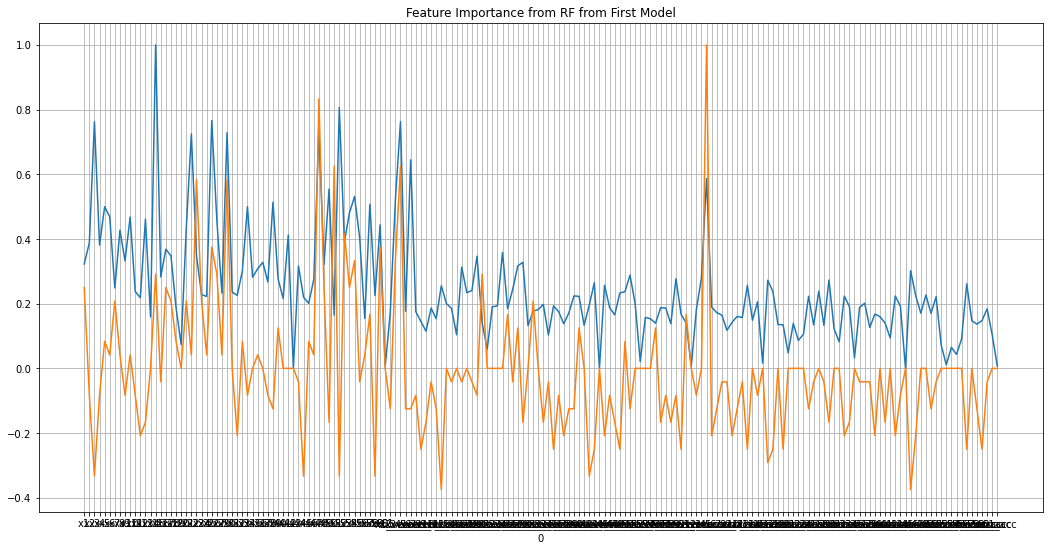

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (18, 9))
#plt.plot(Features.F_I)
plt.plot(df_pva.iloc[:,3:].columns, Features.F_I/max(Features.F_I), label = 'Feature Importance')
plt.plot(df_pva.iloc[:,3:].columns, r.importances_mean/max(r.importances_mean), label = 'Permutation Importance')
plt.title('Feature Importance from RF from First Model')
plt.tick_params(labelbottom=[df_pva.iloc[:,3:].columns])
plt.xlabel(0)
plt.grid('black')
#plt.ylim(0,0.04)
plt.show()

In [48]:
FI_model = [ 'x2','x3', 'x5', 'x6','x8', 'x10', 'x13', 'x15',  'x21', 'x22', 'x26', 'x27', 'x30',
       'x34', 'x39', 'x42', 'x48',  'x50', 'x52', 'x54', 'x55', 'x56', 'x58',  'x60']

PI_model = ['x1','x2', 'x3', 'x7', 'x15', 'x17', 'x18', 'x19',  'x21', 'x23', 'x24', 'x26','x27',
            'x30', 'x39', 'x40', 'x48', 'x49', 'x51', 'x53', 'x54', 'x55', 'x58', 'x60' ] 

### Select the features based on importance whether that is position, velocity, or acceleration.  There is a downside when doing this with respect to the results from the Permutation Importance, where a position feature may be importance, but the corresponding velocity or acceleration feature may have 'negative' importance (meaning the results are better when that feature is shuffled). 
### Note that these models maintain alignment of features in the image (x3, x3_vel, and x3_acc are in the same image column).  There aren't different originating features in the derivative tracks, although that could be another method - picking the best number of position, velocity, and acceleration features separately and stacking them regardless of the feature above or below.

### Take these lists forward and re-run the CNN image classification model. 